In [ ]:
pip install --user scikit-image


Epoch 1/10
44/44 [==============================] - 10s 206ms/step - loss: 1.2350 - accuracy: 0.7500 - val_loss: 10.9482 - val_accuracy: 0.5000
Epoch 2/10


C:\Users\Chris\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 9s 205ms/step - loss: 0.4938 - accuracy: 0.8943 - val_loss: 20.7158 - val_accuracy: 0.5000
Epoch 3/10
44/44 [==============================] - 9s 200ms/step - loss: 0.2967 - accuracy: 0.9443 - val_loss: 25.5048 - val_accuracy: 0.5000
Epoch 4/10
44/44 [==============================] - 9s 207ms/step - loss: 0.2046 - accuracy: 0.9743 - val_loss: 31.6042 - val_accuracy: 0.5000
Epoch 5/10
44/44 [==============================] - 9s 215ms/step - loss: 0.1825 - accuracy: 0.9686 - val_loss: 35.4175 - val_accuracy: 0.5000
Epoch 6/10
44/44 [==============================] - 9s 211ms/step - loss: 0.1697 - accuracy: 0.9707 - val_loss: 25.8124 - val_accuracy: 0.5000
Epoch 7/10
44/44 [==============================] - 9s 198ms/step - loss: 0.1307 - accuracy: 0.9800 - val_loss: 26.5094 - val_accuracy: 0.5000
Epoch 8/10
44/44 [==============================] - 9s 205ms/step - loss: 0.1218 - accuracy: 0.9786 - val_loss: 31.5847 - val_accuracy: 0.5000
Epoch 9/10

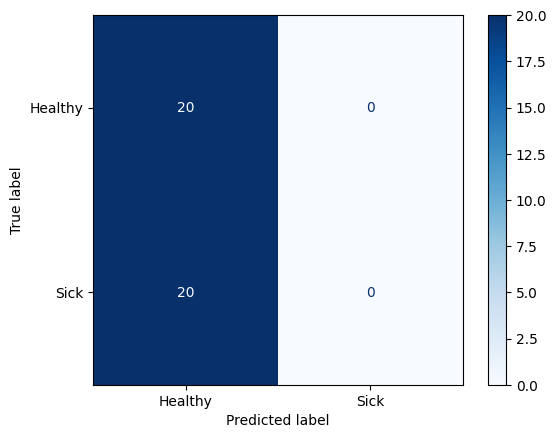

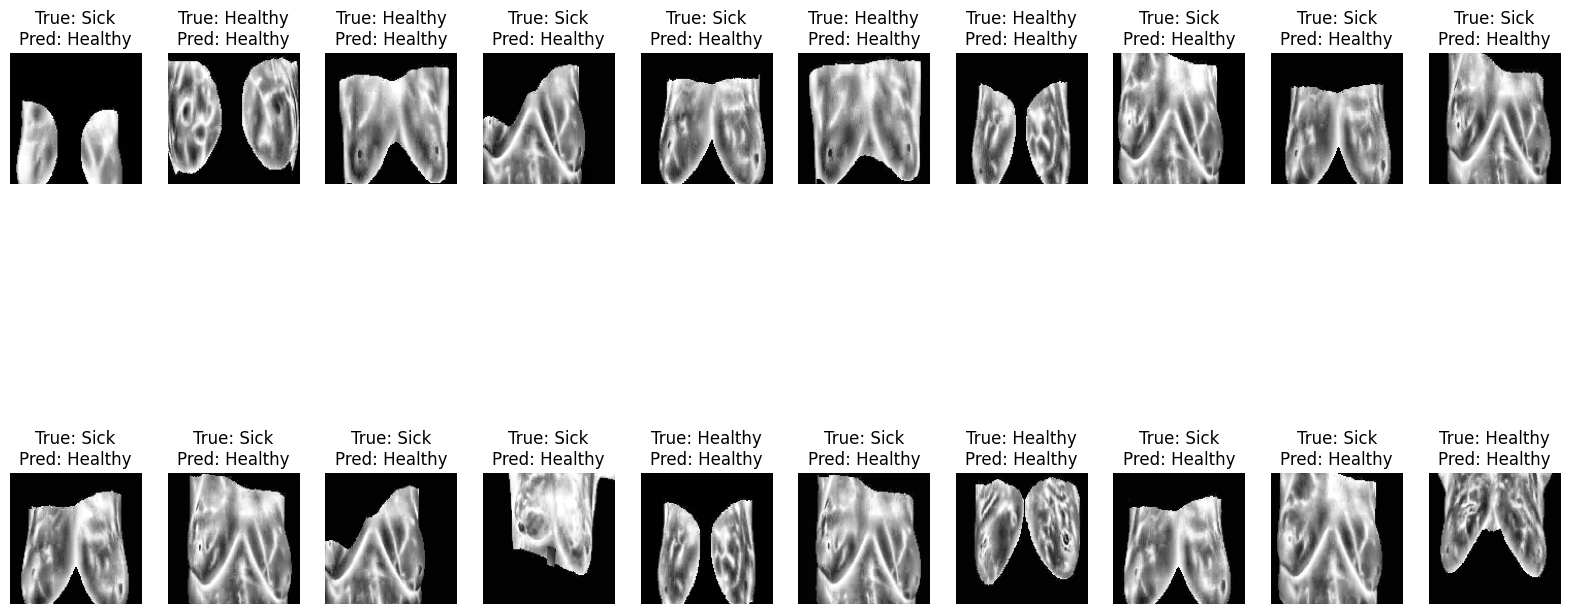

2/2 [==============================] - 0s 15ms/step


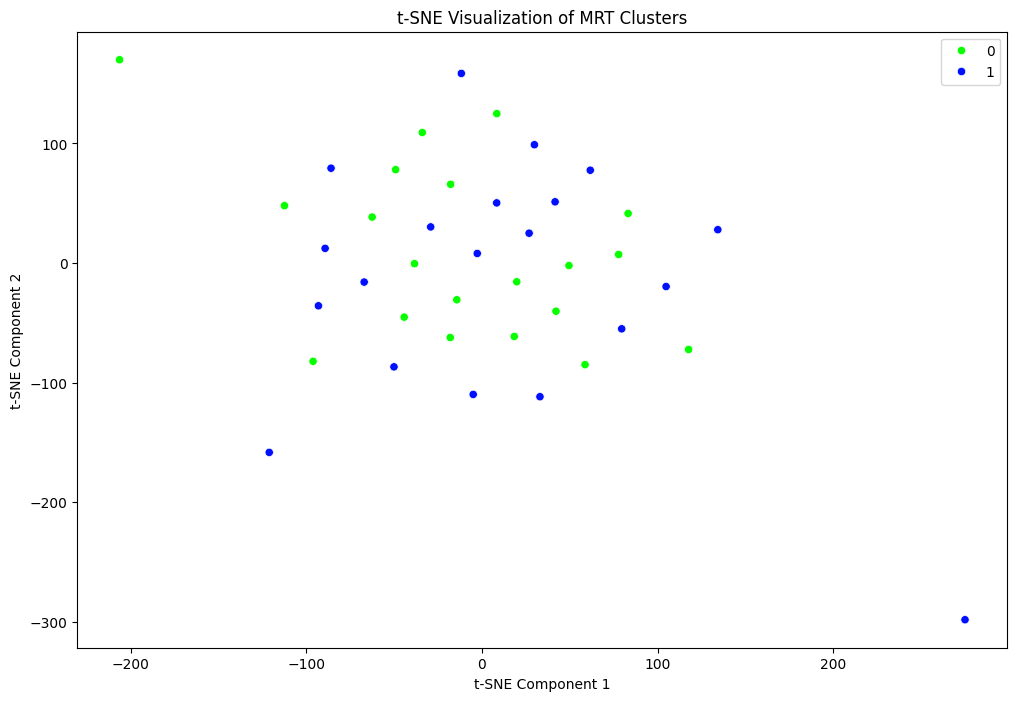

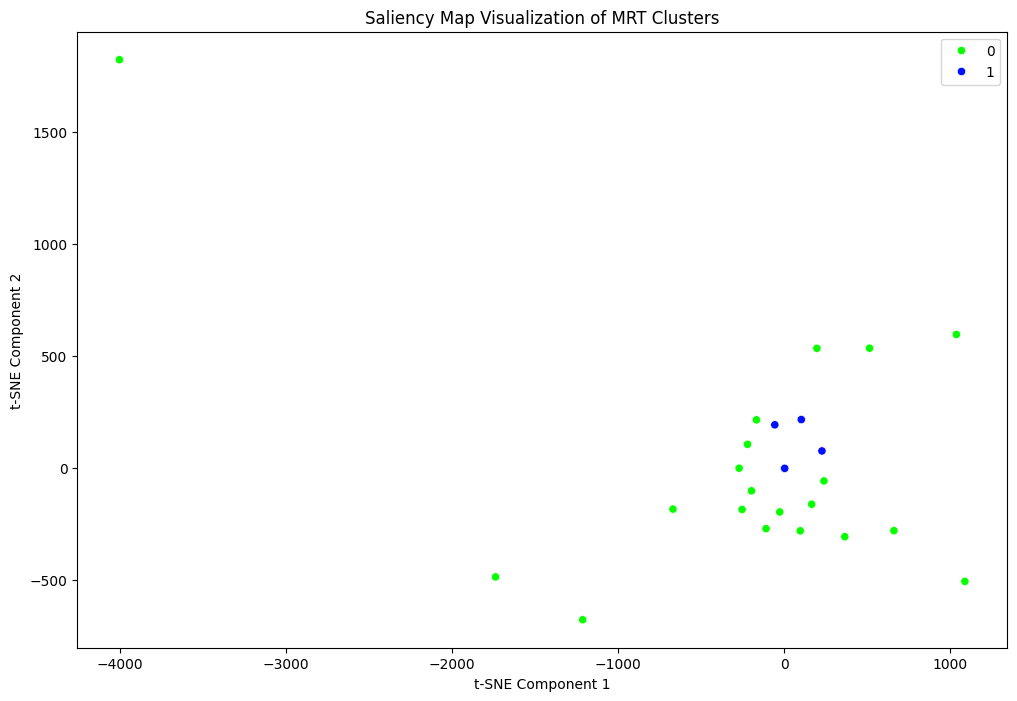

In [16]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from skimage import exposure, img_as_float
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 10

# Define the model creation function
def create_model(input_shape, num_classes):
    model = Sequential([
        InputLayer(input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu', name='dense'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax', name='Classifier')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the model training function
def train_model(model, X_train, y_train, X_val, y_val, class_weights, epochs=epochs, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, checkpoint],
                        class_weight=class_weights)
    return history

# Define the model evaluation function with confusion matrix
def evaluate_model(model, X_test, y_test):
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {test_acc}')
    predictions = model.predict(X_test)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Compute and display the confusion matrix
    cm = confusion_matrix(y_test, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Sick'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    return test_loss, test_acc, predicted_labels

# Extract features from the last hidden layer for visualization
def extract_features(model, X):
    feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer('dense').output)
    features = feature_extractor.predict(X)
    return features

# Visualize clusters using t-SNE
def visualize_clusters(features, labels, title='t-SNE Visualization of Clusters'):
    num_samples = features.shape[0]
    perplexity = min(30, num_samples - 1)
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=300,  learning_rate=300)
    tsne_results = tsne.fit_transform(features)

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette=sns.color_palette('hsv', len(np.unique(labels))))
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(loc='best')
    plt.show()

def visualize_predictions(X_test, y_test, predicted_labels, num_images=10):
    plt.figure(figsize=(20, 10))
    indices = np.random.choice(len(X_test), num_images, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(X_test[idx].reshape(128, 128), cmap='gray')
        true_label = "Healthy" if y_test[idx] == 0 else "Sick"
        predicted_label = "Healthy" if predicted_labels[idx] == 0 else "Sick"
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.show()

# Compute saliency map for interpretability
def get_gradients(model, inputs, class_index):
    inputs = tf.convert_to_tensor(inputs)
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs)[:, class_index]
    gradients = tape.gradient(predictions, inputs)
    return gradients.numpy()

def compute_saliency_map(model, inputs, labels):
    saliency_maps = []
    for i, input_image in enumerate(inputs):
        class_index = labels[i]
        gradients = get_gradients(model, np.expand_dims(input_image, axis=0), class_index)
        saliency_maps.append(gradients[0])
    return np.array(saliency_maps)

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            image = load_img(img_path, target_size=(128, 128), color_mode='grayscale')
            image = img_to_array(image)
            image = img_as_float(image)
            
            # Normalize the image
            image = (image - np.min(image)) / (np.max(image) - np.min(image))
            
            # Adjust brightness and contrast
            image = exposure.adjust_gamma(image, gamma=0.8)
            image = exposure.equalize_adapthist(image, clip_limit=0.03)
            
            images.append(image)
            labels.append(label)
    return images, labels

def preprocess_mrt_data(directory):
    """
    Load and preprocess MRI images of healthy and sick breasts.

    Args:
        directory (str): Directory containing the MRI images.

    Returns:
        tuple: Processed data and labels ready for the neural network.
    """
    train_healthy_dir = os.path.join(directory, 'train', 'healthy')
    train_sick_dir = os.path.join(directory, 'train', 'sick')
    val_healthy_dir = os.path.join(directory, 'validation', 'healthy')
    val_sick_dir = os.path.join(directory, 'validation', 'sick')

    X_train_healthy, y_train_healthy = load_images_from_folder(train_healthy_dir, 0)
    X_train_sick, y_train_sick = load_images_from_folder(train_sick_dir, 1)
    X_val_healthy, y_val_healthy = load_images_from_folder(val_healthy_dir, 0)
    X_val_sick, y_val_sick = load_images_from_folder(val_sick_dir, 1)

    X_train = np.array(X_train_healthy + X_train_sick)
    y_train = np.array(y_train_healthy + y_train_sick)
    X_val = np.array(X_val_healthy + X_val_sick)
    y_val = np.array(y_val_healthy + y_val_sick)

    # Split validation data into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test

def compute_class_weights(y_train):
    classes, counts = np.unique(y_train, return_counts=True)
    total_count = len(y_train)
    class_weights = {cls: total_count / count for cls, count in zip(classes, counts)}
    return class_weights

# Main function to run the entire pipeline
def main(data_type, file_path):
    if data_type == 'CT':
        X_train, y_train, X_val, y_val, X_test, y_test = preprocess_ct_data(file_path)
        num_classes = 2
    elif data_type == 'MRT':
        X_train, y_train, X_val, y_val, X_test, y_test = preprocess_mrt_data(file_path)
        num_classes = 2  # Healthy and Sick
    elif data_type == 'Ultrasound':
        X_train, y_train, X_val, y_val, X_test, y_test = preprocess_ultrasound_data(file_path)
        num_classes = 3  # benign, malignant, normal
    else:
        raise ValueError('Unsupported data type')

    input_shape = X_train.shape[1:]
    class_weights = compute_class_weights(y_train)

    model = create_model(input_shape, num_classes)
    train_model(model, X_train, y_train, X_val, y_val, class_weights, epochs=epochs, batch_size=32)
    test_loss, test_acc, predicted_labels = evaluate_model(model, X_test, y_test)

    # Visualize predictions
    visualize_predictions(X_test, y_test, predicted_labels, num_images=20)

    # Extract features and visualize clusters
    features = extract_features(model, X_test)
    visualize_clusters(features, y_test, title=f't-SNE Visualization of {data_type} Clusters')

    # Compute and visualize saliency maps
    saliency_maps = compute_saliency_map(model, X_test, y_test)
    flattened_saliency_maps = saliency_maps.reshape((saliency_maps.shape[0], -1))
    visualize_clusters(flattened_saliency_maps, y_test, title=f'Saliency Map Visualization of {data_type} Clusters')

# Example usage
data_type = 'MRT'  # Change this to 'CT' or 'MRT' as needed
file_path = './mri'  # Provide the path to your data directory
main(data_type, file_path)


Epoch 1/100
44/44 [==============================] - 10s 211ms/step - loss: 2.3491 - accuracy: 0.5214 - val_loss: 0.7939 - val_accuracy: 0.5000
Epoch 2/100
44/44 [==============================] - 9s 214ms/step - loss: 1.8295 - accuracy: 0.5543 - val_loss: 6.2674 - val_accuracy: 0.5000
Epoch 3/100
44/44 [==============================] - 9s 211ms/step - loss: 1.7277 - accuracy: 0.5536 - val_loss: 5.0649 - val_accuracy: 0.5000
Epoch 4/100
44/44 [==============================] - 9s 203ms/step - loss: 1.5765 - accuracy: 0.5957 - val_loss: 11.3464 - val_accuracy: 0.5000
Epoch 5/100
44/44 [==============================] - 9s 202ms/step - loss: 1.6445 - accuracy: 0.5593 - val_loss: 11.9350 - val_accuracy: 0.5000
Epoch 6/100
44/44 [==============================] - 9s 204ms/step - loss: 1.4973 - accuracy: 0.5736 - val_loss: 6.8541 - val_accuracy: 0.5000
Epoch 7/100
44/44 [==============================] - 9s 206ms/step - loss: 1.4439 - accuracy: 0.5993 - val_loss: 6.4886 - val_accuracy: 0.5

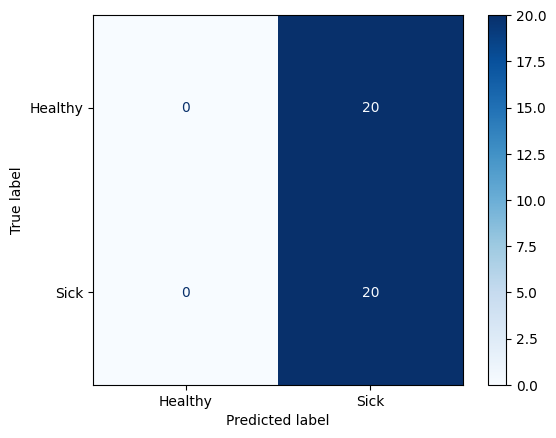

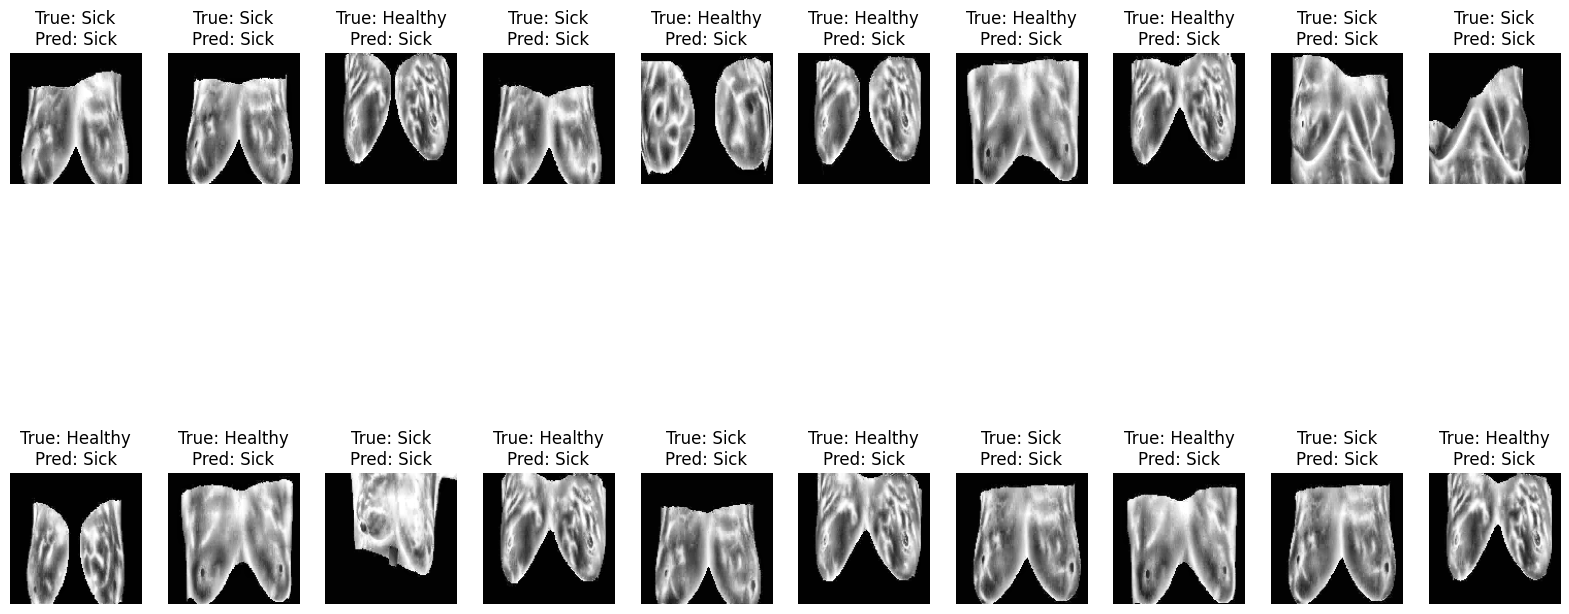

2/2 [==============================] - 0s 17ms/step


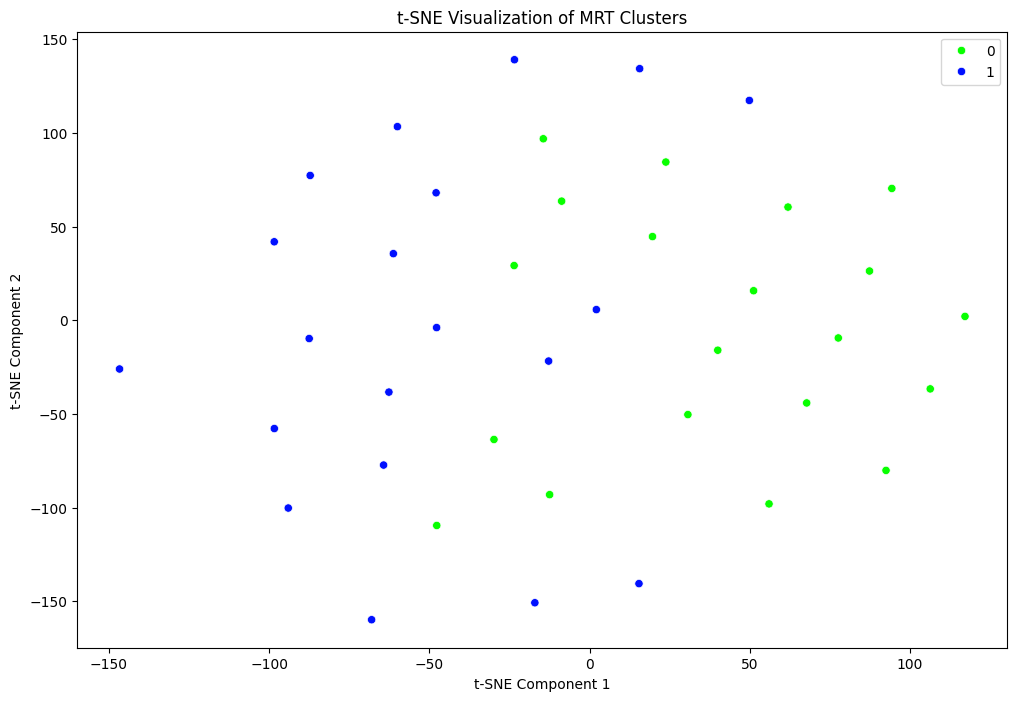

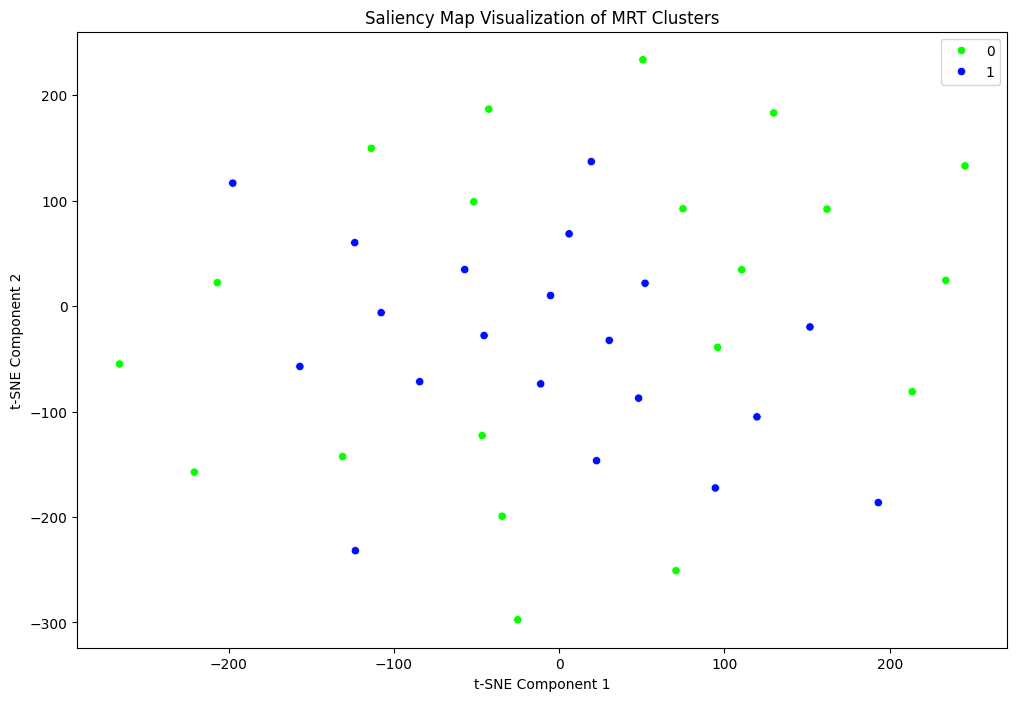

In [17]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from skimage import exposure, img_as_float
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 100

# Define the model creation function
def create_model(input_shape, num_classes):
    model = Sequential([
        InputLayer(input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu', name='dense'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax', name='Classifier')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the model training function
def train_model(model, X_train, y_train, X_val, y_val, class_weights, epochs=50, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    datagen.fit(X_train)

    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, checkpoint],
                        class_weight=class_weights)
    return history

# Define the model evaluation function with confusion matrix
def evaluate_model(model, X_test, y_test):
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {test_acc}')
    predictions = model.predict(X_test)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Compute and display the confusion matrix
    cm = confusion_matrix(y_test, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Sick'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    return test_loss, test_acc, predicted_labels

# Extract features from the last hidden layer for visualization
def extract_features(model, X):
    feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer('dense').output)
    features = feature_extractor.predict(X)
    return features

# Improved Visualize clusters using t-SNE
def visualize_clusters(features, labels, title='t-SNE Visualization of Clusters'):
    # Standardize the features
    features = StandardScaler().fit_transform(features)
    
    # Determine the number of components for PCA
    n_components = min(features.shape[0], features.shape[1], 50)
    
    # Apply PCA to reduce dimensions to a manageable size
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(features)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, learning_rate=200, random_state=42)
    tsne_results = tsne.fit_transform(pca_result)

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette=sns.color_palette('hsv', len(np.unique(labels))))
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(loc='best')
    plt.show()

def visualize_predictions(X_test, y_test, predicted_labels, num_images=10):
    plt.figure(figsize=(20, 10))
    indices = np.random.choice(len(X_test), num_images, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(X_test[idx].reshape(128, 128), cmap='gray')
        true_label = "Healthy" if y_test[idx] == 0 else "Sick"
        predicted_label = "Healthy" if predicted_labels[idx] == 0 else "Sick"
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.show()

# Compute saliency map for interpretability
def get_gradients(model, inputs, class_index):
    inputs = tf.convert_to_tensor(inputs)
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs)[:, class_index]
    gradients = tape.gradient(predictions, inputs)
    return gradients.numpy()

def compute_saliency_map(model, inputs, labels):
    saliency_maps = []
    for i, input_image in enumerate(inputs):
        class_index = labels[i]
        gradients = get_gradients(model, np.expand_dims(input_image, axis=0), class_index)
        saliency_maps.append(gradients[0])
    return np.array(saliency_maps)

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            image = load_img(img_path, target_size=(128, 128), color_mode='grayscale')
            image = img_to_array(image)
            image = img_as_float(image)
            
            # Normalize the image
            image = (image - np.min(image)) / (np.max(image) - np.min(image))
            
            # Adjust brightness and contrast
            image = exposure.adjust_gamma(image, gamma=0.8)
            image = exposure.equalize_adapthist(image, clip_limit=0.03)
            
            images.append(image)
            labels.append(label)
    return images, labels

def preprocess_mrt_data(directory):
    """
    Load and preprocess MRI images of healthy and sick breasts.

    Args:
        directory (str): Directory containing the MRI images.

    Returns:
        tuple: Processed data and labels ready for the neural network.
    """
    train_healthy_dir = os.path.join(directory, 'train', 'healthy')
    train_sick_dir = os.path.join(directory, 'train', 'sick')
    val_healthy_dir = os.path.join(directory, 'validation', 'healthy')
    val_sick_dir = os.path.join(directory, 'validation', 'sick')

    X_train_healthy, y_train_healthy = load_images_from_folder(train_healthy_dir, 0)
    X_train_sick, y_train_sick = load_images_from_folder(train_sick_dir, 1)
    X_val_healthy, y_val_healthy = load_images_from_folder(val_healthy_dir, 0)
    X_val_sick, y_val_sick = load_images_from_folder(val_sick_dir, 1)

    X_train = np.array(X_train_healthy + X_train_sick)
    y_train = np.array(y_train_healthy + y_train_sick)
    X_val = np.array(X_val_healthy + X_val_sick)
    y_val = np.array(y_val_healthy + y_val_sick)

    # Split validation data into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test

def compute_class_weights(y_train):
    classes, counts = np.unique(y_train, return_counts=True)
    total_count = len(y_train)
    class_weights = {cls: total_count / count for cls, count in zip(classes, counts)}
    return class_weights

# Main function to run the entire pipeline
def main(data_type, file_path):
    if data_type == 'CT':
        X_train, y_train, X_val, y_val, X_test, y_test = preprocess_ct_data(file_path)
        num_classes = 2
    elif data_type == 'MRT':
        X_train, y_train, X_val, y_val, X_test, y_test = preprocess_mrt_data(file_path)
        num_classes = 2  # Healthy and Sick
    elif data_type == 'Ultrasound':
        X_train, y_train, X_val, y_val, X_test, y_test = preprocess_ultrasound_data(file_path)
        num_classes = 3  # benign, malignant, normal
    else:
        raise ValueError('Unsupported data type')

    input_shape = X_train.shape[1:]
    class_weights = compute_class_weights(y_train)

    model = create_model(input_shape, num_classes)
    train_model(model, X_train, y_train, X_val, y_val, class_weights, epochs=epochs, batch_size=32)
    test_loss, test_acc, predicted_labels = evaluate_model(model, X_test, y_test)

    # Visualize predictions
    visualize_predictions(X_test, y_test, predicted_labels, num_images=20)

    # Extract features and visualize clusters
    features = extract_features(model, X_test)
    visualize_clusters(features, y_test, title=f't-SNE Visualization of {data_type} Clusters')

    # Compute and visualize saliency maps
    saliency_maps = compute_saliency_map(model, X_test, y_test)
    flattened_saliency_maps = saliency_maps.reshape((saliency_maps.shape[0], -1))
    visualize_clusters(flattened_saliency_maps, y_test, title=f'Saliency Map Visualization of {data_type} Clusters')

# Example usage
data_type = 'MRT'  # Change this to 'CT' or 'MRT' as needed
file_path = './mri'  # Provide the path to your data directory
main(data_type, file_path)
